In [1]:
from pathlib import Path 
import sys 
import os 
PATH = Path.cwd() # '/home/kitadam/ENR_Sven/inugami_curse/src'
sys.path.insert(0, str(Path(PATH).parent))

model_save_dir = '/home/kitadam/ENR_Sven/latent-state-modeling/src/saved_models/'
to_load, model_num = 'DIVA', 249
model_path = os.path.join(model_save_dir, f'{to_load}/{model_num}.pt')

from configs.parsing import get_config_file, set_model_config_based_on_dataset
import argparse 

config_filename = os.path.join(model_save_dir, f'{to_load}/{to_load}.json')
config_dict = get_config_file(config_filename)
print(config_dict)
d = {**config_dict}
args = argparse.Namespace(**d)

import data 
import models 
data_interface = data.DatasetInterface(args.data.pop('return_type'), **args.data)
args = set_model_config_based_on_dataset(args, data_interface)
model_interface = getattr(models, args.model.pop('object'))(**args.model)

import torch 
if isinstance(model_interface, torch.nn.Module): 
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model_interface.load_state_dict(state_dict.state_dict())
    print('Loaded Module from state_dict')

model_interface = model_interface.eval()


{'use_mlflow': False, 'experiment_name': 'DIVA', 'seed': 1, 'data': {'object': 'PulseDataset', 'chunk_size': 10000, 'data_path': '/home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2', 'transform_file': 'transformations.pickle', 'filter_mps': ['IpiFP', 'D_tot', 'k', 'delRoben', 'delRuntn', 'ahor', 'q95', 'P_TOT/P_LH', 'aspect_ratio'], 'split': 0.7, 'return_type': 'pulse', 'sample_interval': 20}, 'model': {'object': 'DIVA', 'state_size_c': 8, 'state_size_not_c': 3, 'min_std_dev': 0.01, 'cond_prior_args': {'activation_function': 'ReLU', 'hidden_sizes': [20, 20]}, 'aux_reg_args': {'activation_function': 'ReLU', 'hidden_sizes': [20]}, 'encoder_args': {'channel_dims': [4, 8, 16, 32], 'kernel_sizes': 4, 'stride_sizes': 2}, 'decoder_args': {'embedding_size': 128, 'channel_dims': [16, 8, 4, 2], 'kernel_sizes': [5, 5, 6, 6], 'stride_sizes': 3}}, 'trainer': {'object': 'DIVATrainInterface', 'learning_rate': 0.02, 'batch_size': 8, 'lr_scheduler': None, 'num_epochs': 250, 'print_inte

10:29:18 | aug_sfutils | INFO: Using version 0.8.6
Traceback (most recent call last):
  File "/home/kitadam/ENR_Sven/inugami_curse/.venv/lib/python3.10/site-packages/aug_sfutils/__init__.py", line 29, in <module>
    from .ww import *
  File "/home/kitadam/ENR_Sven/inugami_curse/.venv/lib/python3.10/site-packages/aug_sfutils/ww.py", line 17, in <module>
    libddww = ct.cdll.LoadLibrary(wwlib)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 452, in LoadLibrary
    return self._dlltype(name)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /afs/ipp-garching.mpg.de/aug/ads/lib64/amd64_sles11/libddww8.so.8.1: cannot open shared object file: No such file or directory
10:29:18 | aug_sfutils | WARNING: ww not loaded
Traceback (most recent call last):
  File "/home/kitadam/ENR_Sven/inugami_curse/.venv/lib/python3.10/site-packages/aug_sfutils/__init__.py", line 34, in <module>
    from .sfh import *
  File "/home

data path /home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2
A ragged map for PROFS exists at /home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2/PROFS_MMAP with length: 2338
A ragged map for MP exists at /home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2/MP_MMAP with length: 2338
A ragged map for RADII exists at /home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2/RADII_MMAP with length: 2338
A ragged map for TIME exists at /home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2/TIME_MMAP with length: 2338
Filtering MPs, keeping ['IpiFP', 'D_tot', 'k', 'delRoben', 'delRuntn', 'ahor', 'q95', 'P_TOT/P_LH', 'aspect_ratio']
loading transformations from /home/kitadam/ENR_Sven/latent-state-modeling/local_data_stability_2/transformations.pickle 
Train/val/test size 1636/140/562
Dataset length : 2338
Loaded Module from state_dict


In [59]:
import numpy as np 

In [57]:
import torch 

from common.interfaces import D, M
m_interface: M = model_interface.model_interface# model_interface
d_interface: D = model_interface.data_interface

train_indicies = data_interface.train_dataset.indices
valid_indicies = data_interface.valid_dataset.indices
test_indicies = data_interface.test_dataset.indices
shot_numbers = data_interface.dataset.shot_numbers
actions_name_list = data_interface.dataset.filter_mps_names
train_shots, valid_shots, test_shots = [[shot_numbers[t] for t in idxs] for idxs in [train_indicies, valid_indicies, test_indicies]]
print(actions_name_list)


['IpiFP', 'D_tot', 'k', 'delRoben', 'delRuntn', 'ahor', 'q95', 'P_TOT/P_LH', 'aspect_ratio']


In [7]:
def shot_prediction(queried_shot: int = 35100):
    # Should return all of the plots for a single shot
    rel_idx = shot_numbers.index(int(queried_shot))
    *batch, shot_num = data_interface.dataset.__getitem__(rel_idx)
    batch_on_device = tuple(item.float().unsqueeze(1) for item in batch)
    if m_interface in [M.DIVA]: 
        observations, actions, radii, time = batch_on_device
        actions_cond, actions_cond_recon = [], []
    elif m_interface in  [None]: 
        observations, actions, radii, time, actions_cond = batch_on_device 
    # TODO: Implement for CCVAE 
    # elif m_interface in [M.Obs_Prof_AUX_MP, M.ProfVAE_MPAUX_split,  M.CCVAE]: 
    #     observations, actions, radii, time, actions_cond = batch_on_device 
    batch_terminus = time > 0

    
    # out = model_interface.forward(observations, actions)
    with torch.no_grad():
        if m_interface == M.DIVA: 
            # observation_reconstructions, [posterior_state, posterior_state_locs, posterior_state_scales], [posterior_state_c, posterior_state_locs_c, posterior_state_scales_c], [posterior_state_not_c, posterior_state_locs_not_c, posterior_state_scales_not_c], [prior_state, prior_state_locs, prior_state_scales], action_reconstructions = out
            [observation_reconstructions_encoder, action_reconstructions_encoder, [posterior_state, posterior_state_locs, posterior_state_scales]], [observation_reconstructions_prior, action_reconstructions_prior, [prior_state, prior_state_locs, prior_state_scales]] = model_interface.inference_all(observations, actions)

    # observation_reconstructions = data_interface.dataset.denorm_profs(observation_reconstructions)[batch_terminus]
    # observations = data_interface.dataset.denorm_profs(observations)[batch_terminus]
    time = time[batch_terminus].numpy()
    data_x = radii[0].cpu().numpy()[0]
    # actions = data_interface.dataset.denorm_mps(actions).numpy()[batch_terminus]
    if m_interface == M.DIVA: 
        # action_reconstructions = data_interface.dataset.denorm_mps(action_reconstructions).numpy()[batch_terminus]
        latent_space_to_return = [[posterior_state, posterior_state_locs, posterior_state_scales], [prior_state, prior_state_locs, prior_state_scales]] 
        observations_to_return = [data_interface.dataset.denorm_profs(obs)[batch_terminus] for obs in [observations, observation_reconstructions_encoder, observation_reconstructions_prior]]
        actions_to_return = [data_interface.dataset.denorm_mps(acts) for acts in [actions, action_reconstructions_encoder, action_reconstructions_prior]]
    else: 
        latent_space_to_return, observations_to_return, actions_to_return = [], [], []


    
    return observations_to_return, actions_to_return, time, data_x, batch_terminus, latent_space_to_return




In [8]:
shot_num = train_shots[4]
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shot_num)

torch.Size([497, 1, 11]) torch.Size([497, 1]) 497
torch.Size([497, 1, 11])


In [125]:
print(height)

2.484855


In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import ListedColormap 
from matplotlib import gridspec
import scienceplots
plt.style.use(['science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
width = textwidth
height = width * aspect_ratio

In [91]:

image_res = 512
sample_size = image_res ** 2 # 2D
r1, r2 = -5, 5
a, b = sample_size, 2

ls_x, ls_y = 0, 6

range_xy = torch.linspace(start=r1, end=r2, steps=image_res)
range_xy = torch.cartesian_prod(range_xy, range_xy)
range_imagecoord = torch.linspace(0, image_res-1, steps=image_res, dtype=torch.int32)  # so we can easily go back
range_imagecoord = torch.cartesian_prod(range_imagecoord, range_imagecoord)


z_mach_mean, z_stoch_mean = latent_space_information[0][1].mean(0).split([model_interface.state_size_c, model_interface.state_size_not_c], -1)
z_mach_sample, z_stoch_sample = torch.tile(z_mach_mean, (sample_size, 1)), torch.tile(z_stoch_mean, (sample_size, 1))


z_mach_sample[:, ls_x] = range_xy[:, 0]
z_mach_sample[:, ls_y] = range_xy[:, 1]


with torch.no_grad(): 
    z_conditional = torch.cat((z_mach_sample, z_stoch_sample), -1).unsqueeze(1)
    # print(z_conditional.shape)
    observation_reconstructions_sweep, action_reconstructions_sweep = model_interface.infer_from_state(z_conditional)
observation_reconstructions_sweep = data_interface.dataset.denorm_profs(observation_reconstructions_sweep)
action_reconstructions_sweep = data_interface.dataset.denorm_mps(action_reconstructions_sweep)

print(observation_reconstructions_sweep.shape)
image_array = torch.zeros((image_res, image_res))

for i in range(range_imagecoord.shape[0]):
    _x, _y = range_imagecoord[i]
    _y = image_res - 1 - _y  # (0, 0) for img are on top left so reverse
    image_array[_y, _x] = 1e-20*observation_reconstructions_sweep[i, 0, 0, -48]



torch.Size([262144, 1, 2, 200])


In [124]:
print(action_info[0][100:110][:, 0, :].mean(dim=0))
for name, val in zip(actions_name_list, action_info[0][100:110][:, 0, :].mean(dim=0)): 
    print(name, val.item())

tensor([ 9.9675e+05,  3.9598e-01,  1.6556e+00,  7.8144e-02,  3.9577e-01,
         5.0068e-01, -4.1689e+00,  1.8427e+00,  3.2114e+00],
       dtype=torch.float64)
IpiFP 996752.6228565834
D_tot 0.3959756890631881
k 1.6555756449067522
delRoben 0.07814361154529016
delRuntn 0.39577401274894547
ahor 0.5006801306975127
q95 -4.168909925875118
P_TOT/P_LH 1.84274257268592
aspect_ratio 3.2114477405869657


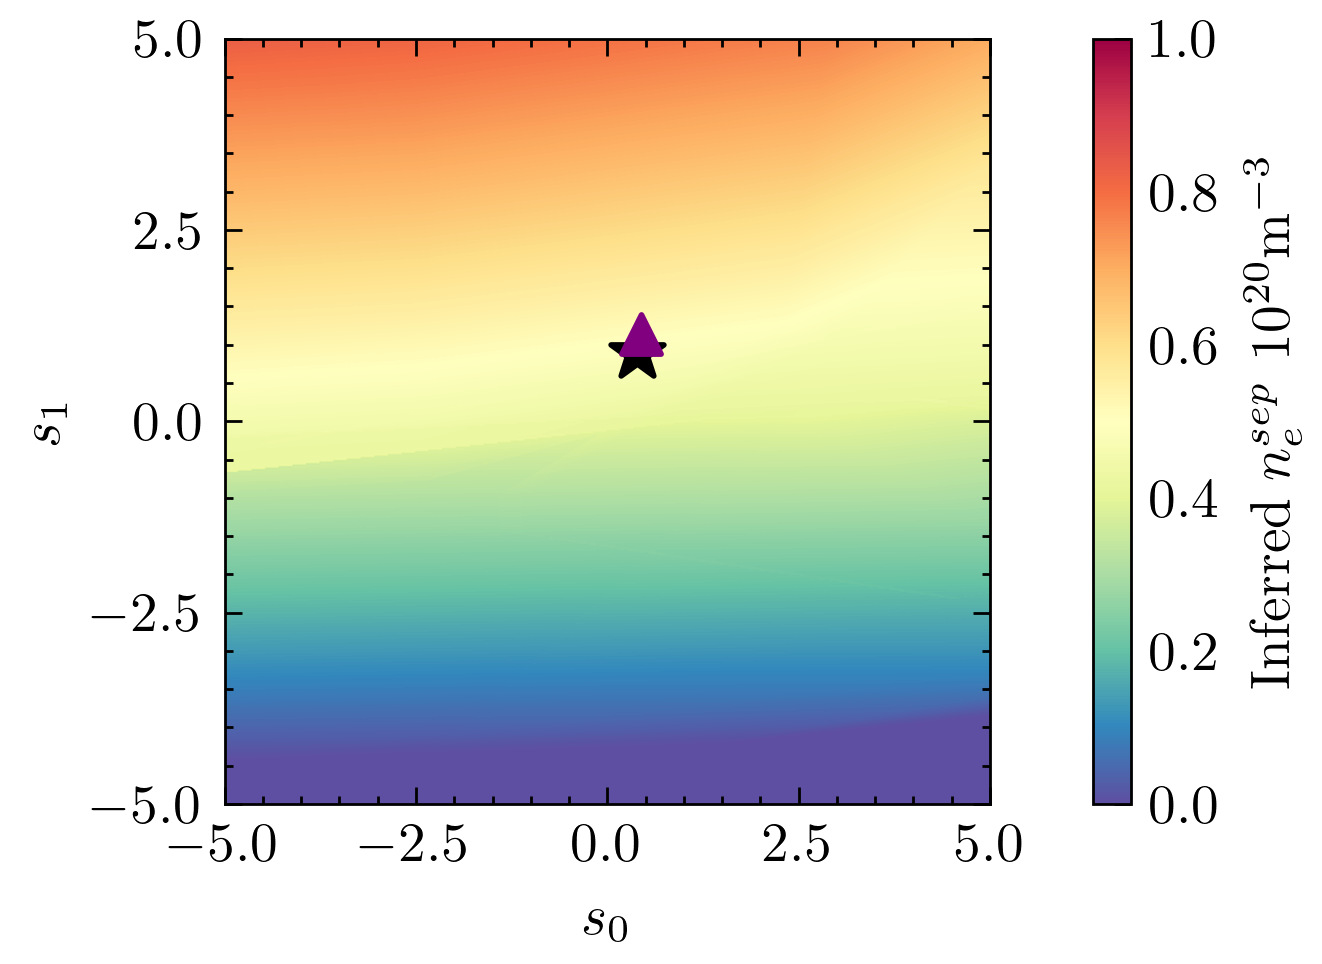

In [96]:

cmap = mpl.cm.Spectral_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig, axs = plt.subplots(figsize=(2*width, height), dpi=400) 

cax = axs.imshow(image_array, extent=[r1, r2, r1, r2], cmap=cmap, norm=norm, interpolation='spline36')
enc_x_to_plot, enc_y_to_plot = latent_space_information[0][0][100:110, 0, ls_x].mean(), latent_space_information[0][0][100:110, 0, ls_y].mean()
axs.scatter(enc_x_to_plot, enc_y_to_plot, s=100,color='green', marker='*')
axs.scatter(latent_space_information[1][0][100:110, 0, ls_x].mean(), latent_space_information[1][0][100:110, 0, ls_y].mean(), s=50, marker='^', color='purple')

axs.set_yticks([-5.0, -2.5, 0.0, 2.5, 5.0])
fig.colorbar(cax, ax=axs, label='Inferred $n_e^{sep}$ $10^{20}$m$^{-3}$')
axs.grid()
axs.set_xlim(-5, 5)
axs.set_ylim(-5, 5)
axs.set_xlabel('$s_0$')
axs.set_ylabel('$s_1$')
plt.show()

torch.Size([10, 2, 200])


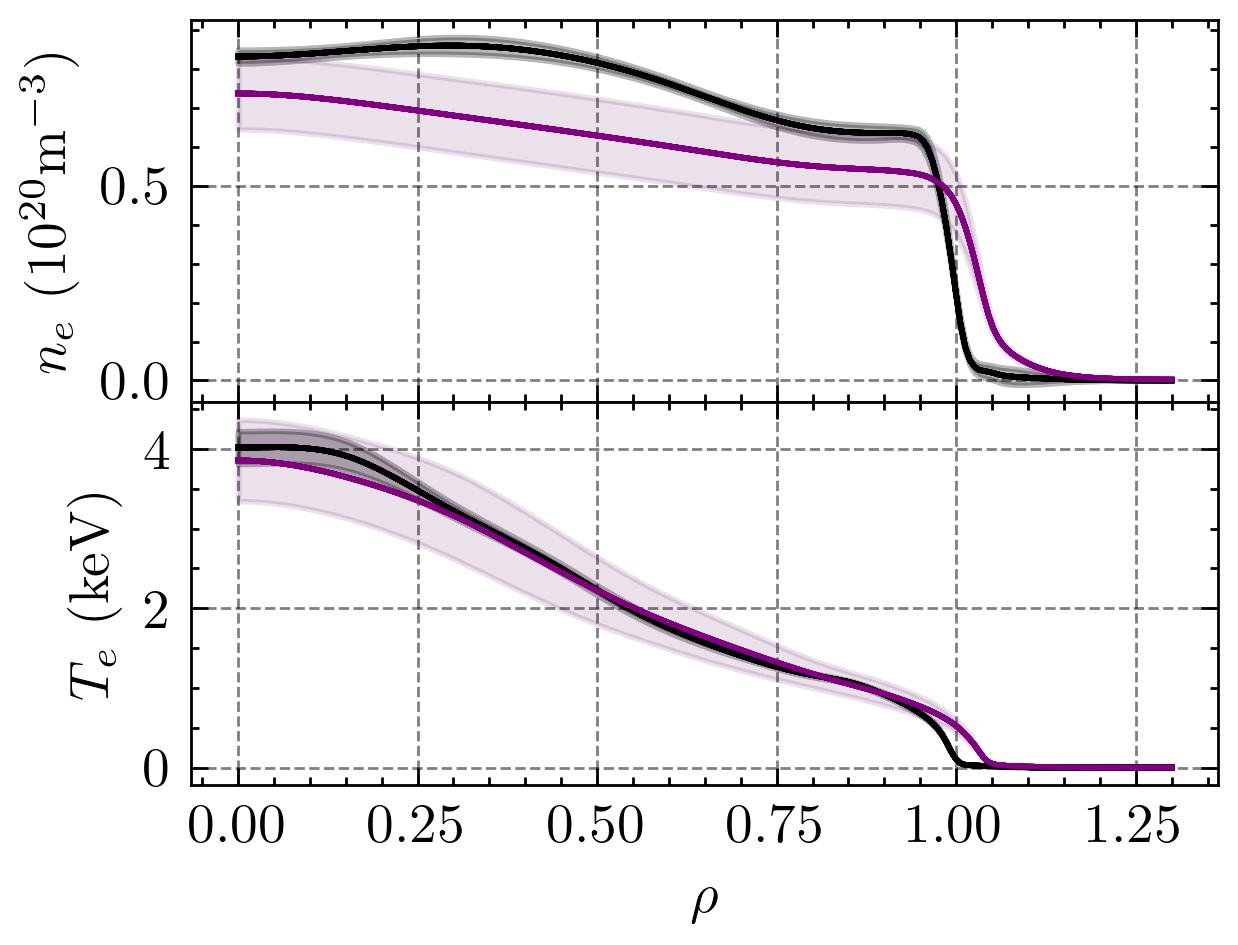

In [118]:
fig, axs = plt.subplots(2, figsize=(width, height), dpi=400) 


t_idx = 100
real_to_plot = observation_info[0][100:110, :]
cond_to_plot = observation_info[2][100:110, :]
print(real_to_plot.shape)
for t_idx in range(10): 
    # axs[0].plot(radius, observation_info[1][t_idx+100, 0], color='red')
    
    axs[0].plot(radius, real_to_plot.mean(dim=0)[0]*1e-20, color='black')
    axs[0].fill_between(radius, real_to_plot.mean(dim=0)[0]*1e-20 + real_to_plot.std(dim=0)[0]*1e-20, real_to_plot.mean(dim=0)[0]*1e-20 - real_to_plot.std(dim=0)[0]*1e-20, color='black', alpha=0.03)
    axs[1].plot(radius, 0.001*real_to_plot.mean(dim=0)[1], color='black')
    axs[1].fill_between(radius, 0.001*real_to_plot.mean(dim=0)[1] + 0.001*real_to_plot.std(dim=0)[1], 0.001*real_to_plot.mean(dim=0)[1] - 0.001*real_to_plot.std(dim=0)[1], color='black', alpha=0.03)
    
    axs[0].plot(radius, 1e-20*cond_to_plot.mean(dim=0)[0], color='purple')
    axs[0].fill_between(radius, 1e-20*cond_to_plot.mean(dim=0)[0] + 1e-20*cond_to_plot.std(dim=0)[0], 1e-20*cond_to_plot.mean(dim=0)[0] - 1e-20*cond_to_plot.std(dim=0)[0], color='purple', alpha=0.01)
    axs[1].plot(radius, 0.001*cond_to_plot.mean(dim=0)[1], color='purple')
    axs[1].fill_between(radius, 0.001*cond_to_plot.mean(dim=0)[1] + 0.001*cond_to_plot.std(dim=0)[1], 0.001*cond_to_plot.mean(dim=0)[1] - 0.001*cond_to_plot.std(dim=0)[1], color='purple', alpha=0.01)
    

axs[0].set_ylabel('$n_e$ $(10^{20}$m$^{-3})$')
axs[1].set_ylabel('$T_e$ (keV)')
axs[1].set_xlabel(r'$\rho$')
fig.subplots_adjust(hspace=0.0)
for ax in axs: 
    ax.label_outer()
# fig.suptitle(f'AUG \# {shot_num}')
plt.show()